In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import font_manager

In [66]:
methods = ['shap', 'signed_normalized_l2_avg', 'signed_normalized_l2_noavg',
           'signed_nonnormalized_l2_avg', 'signed_nonnormalized_l2_noavg',
           'nonl2_avg', 'nonl2_noavg', 'l2_ranking', 'nonl2_ranking',
           'normalized_l2_ranking', 'baseline', 'mdi']
pves = [0.1, 0.4]
rhos = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
mean_results = {}
sd_results = {}
for method in methods:
    group_results = {}
    sd_group_results = {}
    sig_mat = np.zeros((len(pves), len(rhos)))
    c_nsig_mat = np.zeros((len(pves), len(rhos)))
    nsig_mat = np.zeros((len(pves), len(rhos)))
    sig_sd = np.zeros((len(pves), len(rhos)))
    c_nsig_sd = np.zeros((len(pves), len(rhos)))
    nsig_sd = np.zeros((len(pves), len(rhos)))
    for pve_idx in range(len(pves)):
        for rho_idx in range(len(rhos)):
            rankings = np.zeros((250, 100, 50)) # 250 samples, 100 features, 50 seeds
            for seed in range(1, 51):
                if method == 'mdi':
                    ranking = pd.read_csv(f"results/pve{pves[pve_idx]}/rho{rhos[rho_idx]}/seed{seed}/rankings/{method}.csv").to_numpy()
                    # repeat ranking 250 times on axis 0
                    ranking = np.repeat(ranking.T, rankings.shape[0], axis=0)
                    rankings[:, :, seed-1] = ranking
                else:
                    rankings[:, :, seed-1] = pd.read_csv(f"results/pve{pves[pve_idx]}/rho{rhos[rho_idx]}/seed{seed}/rankings/{method}.csv").to_numpy()
            # print(np.mean(rankings, axis = 0).shape)
            sds = np.std(np.mean(rankings, axis = 0), axis=1)/math.sqrt(rankings.shape[0])
            # print(sds.shape)
            rankings = np.mean(rankings, axis=2)
            # average first six columns in rankings
            sig_mat[pve_idx, rho_idx] = np.mean(rankings[:, :6])
            sig_sd[pve_idx, rho_idx] = np.mean(sds[:6])
            # average features 7-50 in rankings
            c_nsig_mat[pve_idx, rho_idx] = np.mean(rankings[:, 6:50])
            c_nsig_sd[pve_idx, rho_idx] = np.mean(sds[6:50])
            # average features 51-100 in rankings
            nsig_mat[pve_idx, rho_idx] = np.mean(rankings[:, 50:])
            nsig_sd[pve_idx, rho_idx] = np.mean(sds[50:])
    group_results['sig'] = sig_mat
    group_results['c_nsig'] = c_nsig_mat
    group_results['nsig'] = nsig_mat
    sd_group_results['sig'] = sig_sd
    sd_group_results['c_nsig'] = c_nsig_sd
    sd_group_results['nsig'] = nsig_sd
    sd_results[method] = sd_group_results
    mean_results[method] = group_results

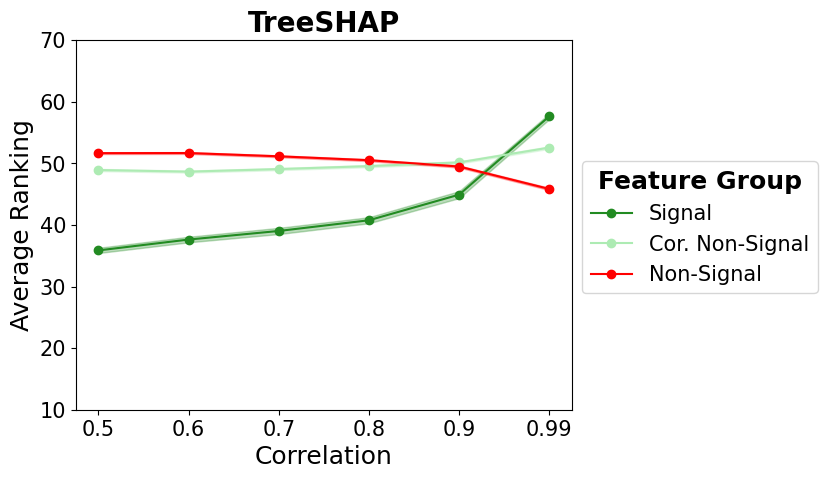

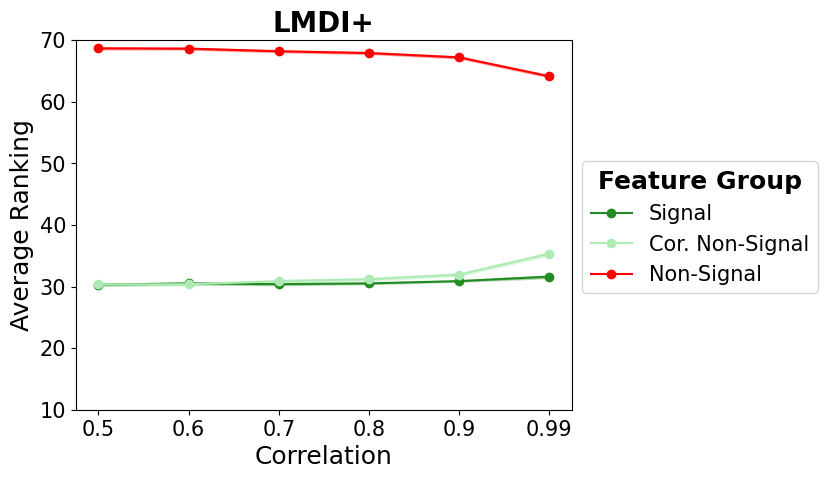

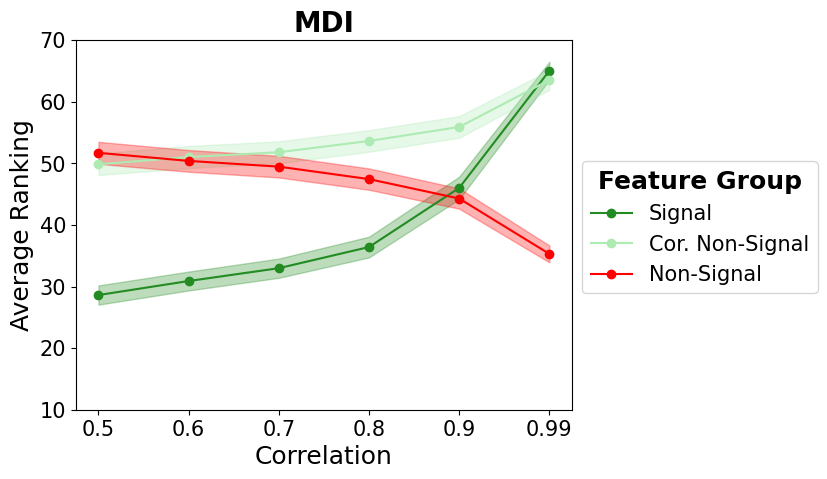

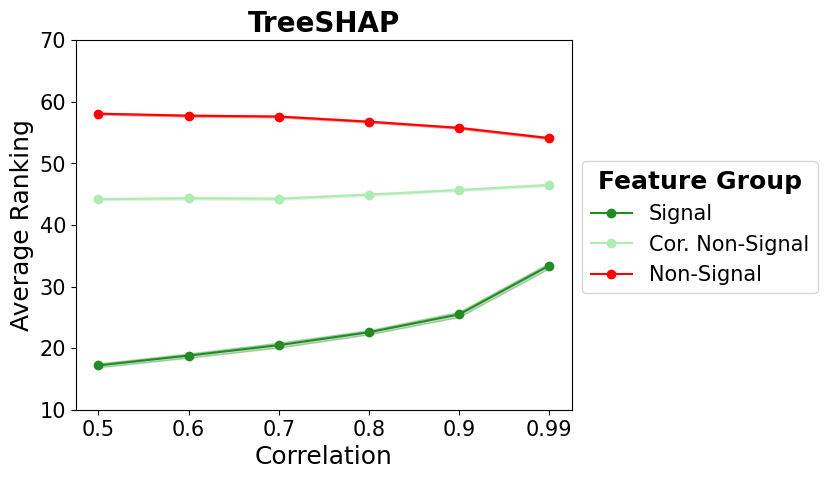

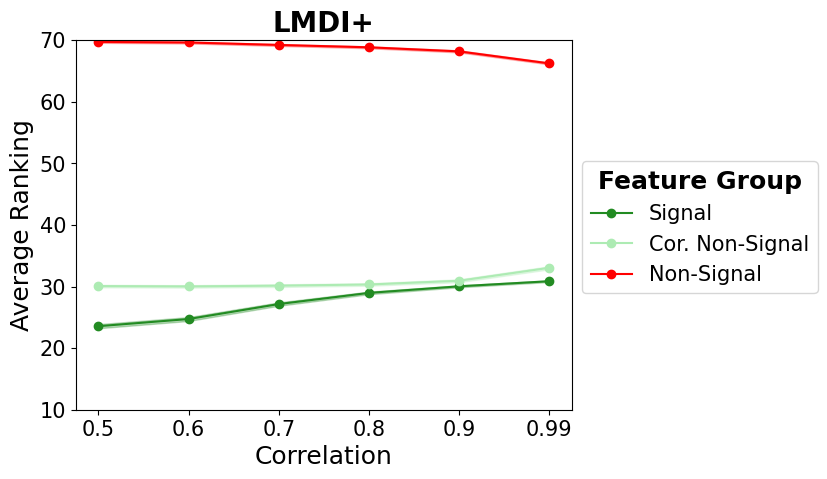

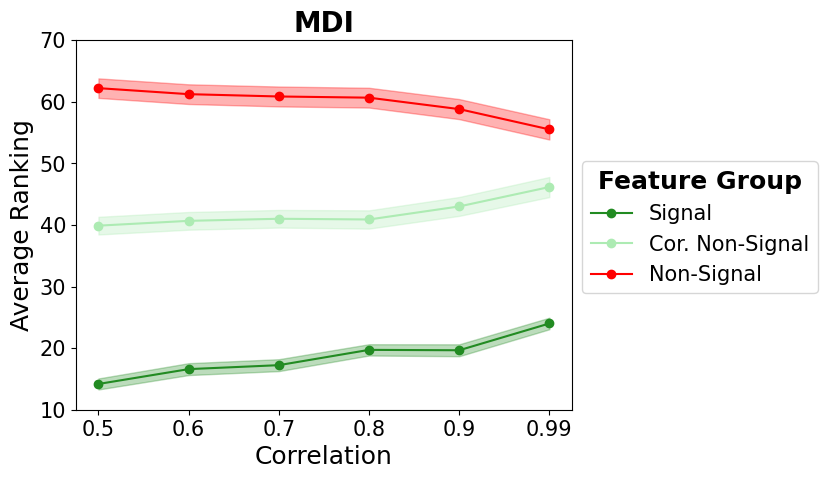

In [67]:
viz_methods = ['shap', 'nonl2_ranking', 'mdi']
titles = {'shap': 'TreeSHAP', 'nonl2_ranking': 'LMDI+', 'mdi': 'MDI'}
for pve_idx in range(len(pves)): 
    for method in viz_methods:
        # plot results, where each group is a separate line on the plot
        plt.plot(mean_results[method]['sig'][pve_idx, :], marker = "o",
                 label="Signal", color='forestgreen')
        plt.fill_between(range(len(rhos)),
                         mean_results[method]['sig'][pve_idx, :] - \
                             sd_results[method]['sig'][pve_idx, :],
                             mean_results[method]['sig'][pve_idx, :] + \
                                 sd_results[method]['sig'][pve_idx, :],
                                 color='forestgreen', alpha=0.3)
        plt.plot(mean_results[method]['c_nsig'][pve_idx, :], marker = "o",
                 label="Cor. Non-Signal", color='#ADEBB3')
        plt.fill_between(range(len(rhos)),
                         mean_results[method]['c_nsig'][pve_idx, :] - \
                             sd_results[method]['c_nsig'][pve_idx, :],
                             mean_results[method]['c_nsig'][pve_idx, :] + \
                                 sd_results[method]['c_nsig'][pve_idx, :],
                                 color='#ADEBB3', alpha=0.3)
        plt.plot(mean_results[method]['nsig'][pve_idx, :], marker = "o",
                 label="Non-Signal", color='red')
        plt.fill_between(range(len(rhos)),
                         mean_results[method]['nsig'][pve_idx, :] - \
                             sd_results[method]['nsig'][pve_idx, :],
                             mean_results[method]['nsig'][pve_idx, :] + \
                                 sd_results[method]['nsig'][pve_idx, :],
                                 color = 'red', alpha=0.3)
        # x-axis ticks should be rho values
        plt.xticks(range(len(rhos)), rhos)
        plt.xlabel("Correlation", fontsize=18)
        # make xaxis label big
        plt.tick_params(axis='both', labelsize=15)
        # y-axis label should be Average Ranking
        plt.ylabel("Average Ranking", fontsize=18)
        plt.title(titles[method], fontsize=20, fontweight='bold')
        # set y-axis limits from 15-70
        plt.ylim(10, 70)
        # put legend to the right of the plot
        # plt.legend()
        title_font_properties = font_manager.FontProperties(weight='bold', size=18)
        plt.legend(title = "Feature Group", loc = "upper left", bbox_to_anchor=(1,0.7), fontsize=15, title_fontproperties = title_font_properties)
        plt.show()